# Approach
1. Clear out and remove irrelevant points(far away, clustering of points that are very close(<0.5m))
2. Divide the points into prior regions
3. For each region, apply convex hull, concave hull, delauney triangles - http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/
4. Custom algorithm to detect points facing the car- connect car(0,0) to each point. If the line connecting the point and the car intersects any of the lines of the delauney traingles, remove that point. The points that remain should be the boundary points.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.cluster import DBSCAN
from sklearn import metrics
import pylab as pl
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import math
from shapely.ops import cascaded_union, polygonize
import shapely.geometry as geometry
# from matplotlib import animation, rc
# from IPython.display import HTML
from IPython import display
pl.ion()

In [3]:
csvs = sorted(glob.glob("./*.csv"))

352


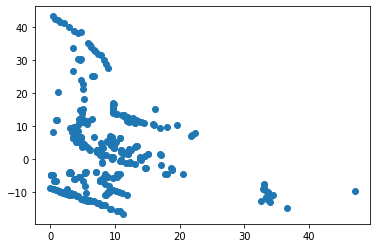

In [31]:
df = pd.read_csv("./frame_pointclouds/frame_90.csv")
print(len(df))
pl.scatter(df.x,df.y)

In [4]:
X = df.to_numpy()[:,:2]
db = DBSCAN(eps=0.5, min_samples=2).fit(X)

Estimated number of clusters: 46
Estimated number of noise points: 64


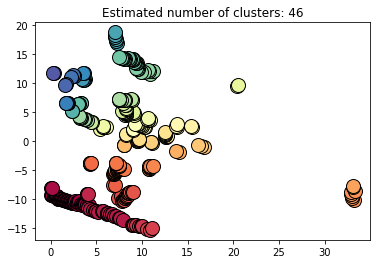

In [5]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

#     xy = X[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [6]:
df.to_numpy()[:,:2].shape

(351, 2)

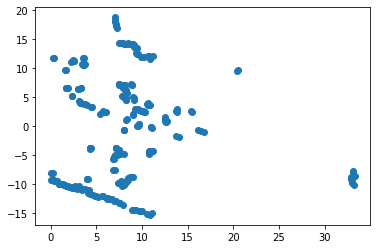

In [7]:
pl.scatter(X[db.core_sample_indices_][:,0],X[db.core_sample_indices_][:,1])

In [8]:
filtered_X = X[db.core_sample_indices_]

In [9]:
# using 2 priors for now (y>0 and y<0)
# prior1 = df[df.y>0].to_numpy()[:,:2]
# prior2 = df[df.y<=0].to_numpy()[:,:2]
prior1= filtered_X[filtered_X[:,1]>0,:]
prior2 = filtered_X[filtered_X[:,1]<=0,:]

# # add points to prior
# 0,maxY and maxX,maxY to prior1
# 0, minY and maxX,minY to prior2

maxX = np.max(filtered_X[:,0])
maxY = np.max(filtered_X[:,1])
minY = np.min(filtered_X[:,1])
# print(prior1.shape, prior2.shape)
# print(maxX,maxY,minY)
prior1 = np.vstack([prior1,np.array([[0,maxY],[maxX,maxY]])])
prior2 = np.vstack([prior2,np.array([[0,minY],[maxX,minY]])])
# print(prior1.shape, prior2.shape)


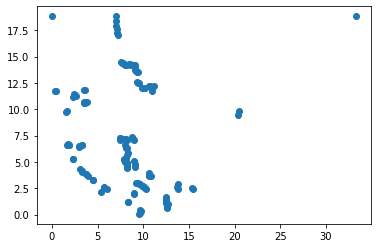

In [10]:
pl.scatter(prior1[:,0],prior1[:,1])

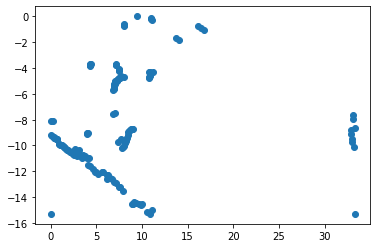

In [11]:
pl.scatter(prior2[:,0],prior2[:,1])

In [12]:
hull1 = ConvexHull(prior1)

In [13]:
hull2 = ConvexHull(prior2)

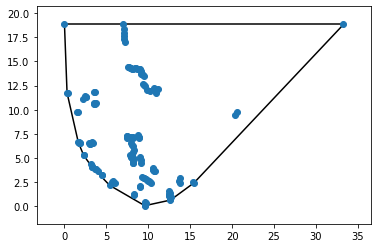

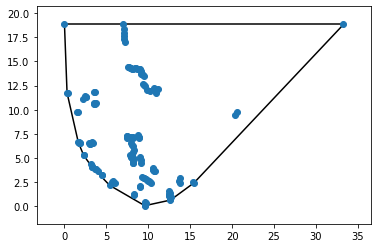

In [14]:
convex_hull_plot_2d(hull1)

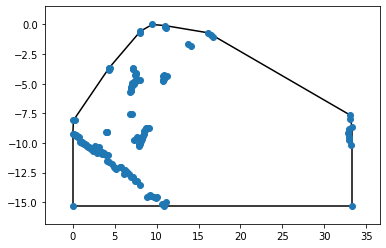

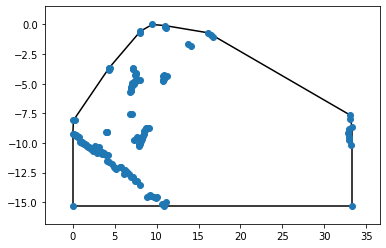

In [15]:
convex_hull_plot_2d(hull2)

In [16]:
added_vertices_prior1 = [prior1.shape[0]-1,prior1.shape[0]-2]
added_vertices_prior2 = [prior2.shape[0]-1,prior2.shape[0]-2]


    

hull1.vertices
v1 = list(hull1.vertices)
for v in added_vertices_prior1:
    v1.remove(v)

hull2.vertices
v2 = list(hull2.vertices)
for v in added_vertices_prior2:
    v2.remove(v)


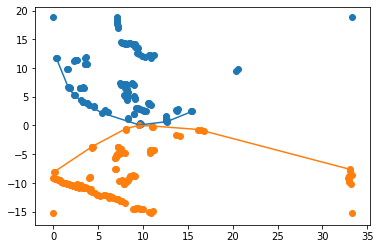

In [17]:
boundary1 = prior1[v1]
boundary2 = prior2[v2]
pl.scatter(prior1[:,0],prior1[:,1])
pl.plot(boundary1[:,0],boundary1[:,1])
pl.scatter(prior2[:,0],prior2[:,1])
pl.plot(boundary2[:,0],boundary2[:,1])

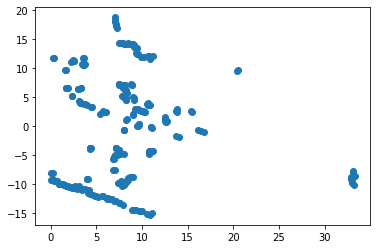

In [18]:
pl.scatter(X[db.core_sample_indices_][:,0],X[db.core_sample_indices_][:,1])

In [19]:
from scipy.spatial import Delaunay

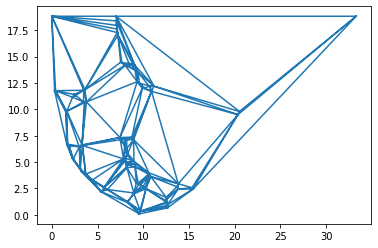

In [20]:
tri = Delaunay(prior1)
plt.triplot(prior1[:,0], prior1[:,1], tri.simplices.copy())

In [21]:
prior1[tri.simplices].shape # array of triangles

(269, 3, 2)

In [22]:
prior1.shape

(141, 2)

In [26]:
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
    
#     coords = np.array([point.coords[0]
#                        for point in points])
    coords = points
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

from descartes import PolygonPatch
def plot_polygon(polygon):
    fig = pl.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3
    x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig

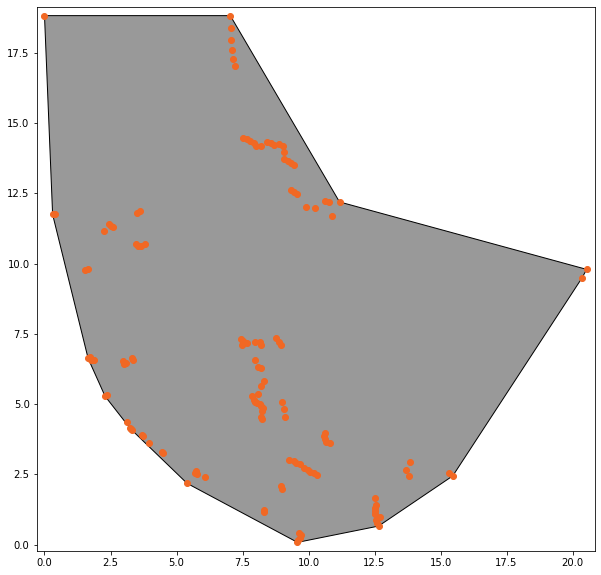

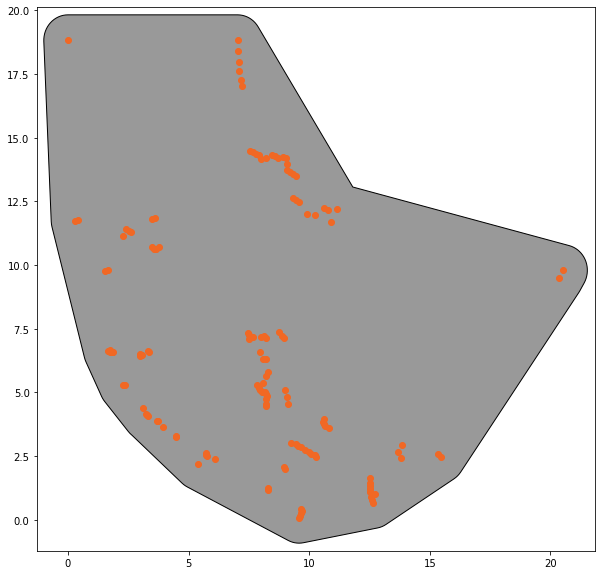

In [43]:
concave_hull, edge_points = alpha_shape(prior1,0.1)
plot_polygon(concave_hull)
_ = pl.plot(prior1[:,0],prior1[:,1],'o', color='#f16824')
plot_polygon(concave_hull.buffer(1))
_ = pl.plot(prior1[:,0],prior1[:,1],'o', color='#f16824')

In [40]:
# edge_points

[array([[20.3591 ,  9.4936 ],
        [20.5334 ,  9.79392]]), array([[20.5334 ,  9.79392],
        [11.1733 , 12.1935 ]]), array([[11.1733, 12.1935],
        [20.3591,  9.4936]]), array([[10.9067, 11.696 ],
        [20.3591,  9.4936]]), array([[11.1733, 12.1935],
        [10.9067, 11.696 ]]), array([[ 3.62528, 11.8578 ],
        [ 7.15584, 17.2757 ]]), array([[ 7.15584, 17.2757 ],
        [ 0.     , 18.8205 ]]), array([[ 0.     , 18.8205 ],
        [ 3.62528, 11.8578 ]]), array([[8.29536 , 1.16584 ],
        [9.64966 , 0.421313]]), array([[9.64966 , 0.421313],
        [8.30802 , 1.24164 ]]), array([[8.30802, 1.24164],
        [8.29536, 1.16584]]), array([[13.8376 ,  2.94128],
        [15.335  ,  2.5662 ]]), array([[15.335 ,  2.5662],
        [20.3591,  9.4936]]), array([[20.3591 ,  9.4936 ],
        [13.8376 ,  2.94128]]), array([[15.335  ,  2.5662 ],
        [15.4639 ,  2.44924]]), array([[15.4639 ,  2.44924],
        [20.3591 ,  9.4936 ]]), array([[ 7.52895, 14.463  ],
        [ 7.23